In [1]:
from huggingface_hub import login
login(new_session=False)


In [2]:

!pip install  pip 
!pip install  torch
!pip install  transformers
!pip install  datasets
!pip install  accelerate
!pip install  bitsandbytes 
!pip install  peft
!pip install trl==0.9.4
!pip install  colored 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [3]:
# Imports
import random
from textwrap import dedent
from typing import Dict, List

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from colored import Back, Fore, Style
from datasets import Dataset, load_dataset
from matplotlib.ticker import PercentFormatter
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from trl import SFTConfig, SFTTrainer
from trl.trainer.utils import DataCollatorForCompletionOnlyLM

# Plotting magic (for Jupyter Notebooks; remove if running as .py script)
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

# Color palette
COLORS = ["#bae1ff", "#ffb3ba", "#ffdfba", "#ffffba", "#baffc9"]

# Seaborn and matplotlib style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
sns.set_palette(sns.color_palette(COLORS))

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", COLORS[:2])

# Matplotlib style config (fixed all key typos and line styles)
MY_STYLE = {
    "figure.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "axes.linewidth": 0.5,
    "text.color": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.grid": True,
    "xtick.labelsize": "medium",
    "ytick.labelsize": "medium",
    "axes.titlesize": "large",
    "axes.labelsize": "large",
    "lines.color": COLORS[0],
    "patch.edgecolor": "white",
}
mpl.rcParams.update(MY_STYLE)

# Set seed for reproducibility
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(SEED)

# Constants
PAD_TOKEN = "<|pad|>"
MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
NEW_MODEL = "Llama-3-8B-Instruct-MedQuad-MedicalQna"


2025-09-07 16:48:23.911502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757263704.240648      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757263704.332388      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.padding_side = "right"

max_mem = {0: "14GiB", "cpu": "32GiB"}  # leave some buffer
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quantization_config,
    device_map="auto",
    max_memory=max_mem,
)


model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=8)



tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(128264, 4096)

# DATASET PREPROCESSING

In [5]:
dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

README.md:   0%|          | 0.00/233 [00:00<?, ?B/s]

medDataset_processed.csv:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16407 [00:00<?, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['qtype', 'Question', 'Answer'],
        num_rows: 16407
    })
})

In [7]:
rows = []
for item in dataset ["train"]:
    rows. append(
    {
    "qtype": item["qtype"],
    "question": item["Question"],
    "answer": item["Answer"],
    }
    )
df = pd.DataFrame(rows)

df.head()

,qtype,question,answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [8]:
df.isnull().value_counts()

qtype  question  answer
False  False     False     16407
Name: count, dtype: int64

In [9]:
def format_example(row: dict):
    prompt=dedent(
        f"""
        {row["question"]}
        Type:
        
        '''
        {row["qtype"]}
        '''
    
        """
    )
    messages = [
        {
            "role": "system",
            "content": f"You are a helpful medical assistant. The question type is: {row['qtype']}."
        },
        {
            "role": "user",
            "content": row["question"]
        },
        {
            "role": "assistant",
            "content": row["answer"]
        }
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)


In [10]:
df["text"]=df.apply(format_example,axis=1)

In [11]:
df.head()

,qtype,question,answer,text
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,<|begin_of_text|><|start_header_id|>system<|en...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,<|begin_of_text|><|start_header_id|>system<|en...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,<|begin_of_text|><|start_header_id|>system<|en...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...",<|begin_of_text|><|start_header_id|>system<|en...
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...",<|begin_of_text|><|start_header_id|>system<|en...


In [11]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        ) ["input_ids"]
    )

In [12]:
df["token_count"] = df.apply(count_tokens, axis=1)

df.head()

,qtype,question,answer,text,token_count
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,<|begin_of_text|><|start_header_id|>system<|en...,139
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,<|begin_of_text|><|start_header_id|>system<|en...,578
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,<|begin_of_text|><|start_header_id|>system<|en...,182
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...",<|begin_of_text|><|start_header_id|>system<|en...,194
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...",<|begin_of_text|><|start_header_id|>system<|en...,142


In [14]:
len(df[df.token_count<512]) ,len(df) 

(14271, 16407)

In [13]:
df=df[df.token_count<512]
len(df)

14271

In [16]:
# !pip install -q plotly
# import plotly.express as px
# import plotly.graph_objects as go


In [17]:
# fig = px.bar(
#     df["qtype"].value_counts().reset_index(),
#     x="count",
#     y="qtype",
#     orientation="h",
#     color="qtype",
#     title="Distribution of Question Types",
#     labels={"qtype":"Question Type", "count":"Count"}
# )
# fig.update_layout(showlegend=False)
# fig.show()


In [14]:
rare = df.groupby("qtype").filter(lambda x: len(x) < 2)
df_rest = df.drop(rare.index)

train, temp = train_test_split(
    df_rest,
    test_size=0.2,
    random_state=42,
    stratify=df_rest["qtype"]
)
val,test=train_test_split(temp,test_size=0.2)
# add rare categories back into train
train = pd.concat([train, rare]).reset_index(drop=True)

In [19]:
len(df) , len(train), len(val), len(test) 

(14271, 11417, 2283, 571)

In [20]:
print(train['qtype'].value_counts())
print(val['qtype'].value_counts())
print(test['qtype'].value_counts())


qtype
information        3323
treatment          1732
symptoms           1525
inheritance        1149
frequency           896
genetic changes     807
causes              503
exams and tests     353
research            289
outlook             287
susceptibility      214
considerations      170
prevention          126
complications        32
stages               10
support groups        1
Name: count, dtype: int64
qtype
information        679
treatment          340
symptoms           299
inheritance        233
frequency          180
genetic changes    162
causes              95
exams and tests     66
outlook             60
research            56
susceptibility      41
considerations      38
prevention          27
complications        5
stages               2
Name: count, dtype: int64
qtype
information        152
treatment           93
symptoms            82
inheritance         54
frequency           44
genetic changes     40
causes              31
exams and tests     22
research         

In [15]:
train.to_json("/kaggle/working/train.json", orient="records", lines=True)
val.to_json("/kaggle/working/val.json", orient="records", lines=True)
test.to_json("/kaggle/working/test.json", orient="records", lines=True)

dataset = load_dataset(
    "json",
    data_files={
        "train": "/kaggle/working/train.json",
        "validation": "/kaggle/working/val.json",
        "test": "/kaggle/working/test.json"
    }
)


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [22]:
print(dataset)
print(dataset["train"][0])


DatasetDict({
    train: Dataset({
        features: ['qtype', 'question', 'answer', 'text', 'token_count'],
        num_rows: 11417
    })
    validation: Dataset({
        features: ['qtype', 'question', 'answer', 'text', 'token_count'],
        num_rows: 2283
    })
    test: Dataset({
        features: ['qtype', 'question', 'answer', 'text', 'token_count'],
        num_rows: 571
    })
})
{'qtype': 'frequency', 'question': 'How many people are affected by Beckwith-Wiedemann syndrome ?', 'answer': 'Beckwith-Wiedemann syndrome affects an estimated 1 in 13,700 newborns worldwide. The condition may actually be more common than this estimate because some people with mild symptoms are never diagnosed.', 'text': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a helpful medical assistant. The question type is: frequency.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHow many people are affected by Beckwith-Wiedemann syndrome ?<|eot_id|><|start_header_id|>assi

# BASELINE

In [16]:
pipe = pipeline(
task="text-generation",
model=model,
tokenizer=tokenizer,
max_new_tokens=128,
return_full_text=False,
)


Device set to use cuda:0


In [17]:
def create_test_prompt(data_row: dict):
    
    messages = [
        {
            "role": "system",
            "content": f"You are a helpful medical assistant. The question type is: {data_row['qtype']}."
        },
        {
            "role": "user",
            "content": data_row["question"]
        }
    ]
    return tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )


In [18]:
row=dataset["test"][0]
prompt=create_test_prompt(row)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful medical assistant. The question type is: susceptibility.<|eot_id|><|start_header_id|>user<|end_header_id|>

Who is at risk for Parasites - Loiasis? ?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [26]:
%%time
outputs=pipe(prompt)
print(outputs[0]["generated_text"])

Parasites - Loiasis is caused by the filarial parasite Loa loa, which is typically spread through the bite of an infected deer fly (Chrysops spp.). The risk of contracting Loiasis is generally highest in individuals who live in or travel to areas where the parasite is common.

The following groups are at increased risk for Loiasis:

1. Travelers to areas where Loa loa is endemic, such as:
	* Central and West Africa, particularly in countries like Cameroon, Democratic Republic of Congo, Republic of Congo, and Gabon.
	* West Africa, including countries like Nigeria, Ghana, and
CPU times: user 10.1 s, sys: 177 ms, total: 10.2 s
Wall time: 10.8 s


In [32]:
!pip install evaluate sacrebleu bert-score
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.9 MB/s eta 0:00:00


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
# import evaluate

# # Load metrics
# bleu = evaluate.load("bleu")
# rouge = evaluate.load("rouge")
# bertscore = evaluate.load("bertscore")

# # Example: use small sample from test set
# predictions = []
# references = []

# for row in dataset["test"].select(range(100)):  # limit for speed
#     prompt = create_test_prompt(row)
#     output = pipe(prompt, max_new_tokens=128, do_sample=False)
#     pred = output[0]["generated_text"].split(prompt)[-1].strip()  # strip prompt from output
    
#     predictions.append(pred)
#     references.append(row["answer"])  # true answer

# # Compute BLEU
# bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
# print("BLEU:", bleu_result)

# # Compute ROUGE
# rouge_result = rouge.compute(predictions=predictions, references=references)
# print("ROUGE:", rouge_result)

# # Compute BERTScore
# bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
# print("BERTScore F1:", sum(bertscore_result["f1"]) / len(bertscore_result["f1"]))


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

BLEU: {'bleu': 0.04865242602596095, 'precisions': [0.4081732653861231, 0.11312351543942993, 0.04458216713314674, 0.021607431340872375], 'brevity_penalty': 0.5957500116350796, 'length_ratio': 0.6587901091096907, 'translation_length': 10204, 'reference_length': 15489}
ROUGE: {'rouge1': 0.31446440734277725, 'rouge2': 0.09346358847327943, 'rougeL': 0.19652889058335968, 'rougeLsum': 0.22513630799022066}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore F1: 0.8486184620857239


In [35]:
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU:", bleu_result)

# Compute ROUGE
rouge_result = rouge.compute(predictions=predictions, references=references)
print("ROUGE:", rouge_result)

# Compute BERTScore
bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="en")
print("BERTScore F1:", sum(bertscore_result["f1"]) / len(bertscore_result["f1"]))


BLEU: {'bleu': 0.04865242602596095, 'precisions': [0.4081732653861231, 0.11312351543942993, 0.04458216713314674, 0.021607431340872375], 'brevity_penalty': 0.5957500116350796, 'length_ratio': 0.6587901091096907, 'translation_length': 10204, 'reference_length': 15489}
ROUGE: {'rouge1': 0.31446440734277725, 'rouge2': 0.09346358847327943, 'rougeL': 0.19652889058335968, 'rougeLsum': 0.22513630799022066}
BERTScore F1: 0.8486184620857239


In [21]:
from peft import PeftModel

#base_model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct", device_map="auto")
model = PeftModel.from_pretrained(model, "Arushp1/llama3-medquad-qlora")


/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.base_model.model.base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', '

In [22]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    max_new_tokens=256,
    do_sample=False  # deterministic outputs for evaluation
)


Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [23]:
from tqdm import tqdm

preds, refs = [], []

for row in dataset["test"].select(range(100)):
    prompt = create_test_prompt(row)
    output = pipe(prompt, max_new_tokens=256)[0]["generated_text"]
    
    preds.append(output)
    refs.append(row["answer"])


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

In [25]:
clean_preds = []
for prompt, full_output in zip(dataset["test"].select(range(100)), preds):
    # remove the prompt part, keep only generated continuation
    generated_part = full_output.split(prompt["question"])[-1].strip()
    clean_preds.append(generated_part)

# Replace preds with cleaned predictions
preds = clean_preds


In [27]:
!pip install evaluate sacrebleu bert-score rouge_score


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2fcd78eed94a8cbfc560a6247160e2a6df4921770faca2f687c4338185307f0d
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [33]:
from evaluate import load

# BLEU
bleu = load("bleu")
bleu_res = bleu.compute(predictions=preds, references=[[r] for r in refs])

# ROUGE
rouge = load("rouge")
rouge_res = rouge.compute(predictions=preds, references=refs)

# BERTScore
bertscore = load("bertscore")
bert_res = bertscore.compute(predictions=preds, references=refs, lang="en")

print("✅ Evaluation Results")
print("BLEU:", bleu_res["bleu"])
print("ROUGE-1:", rouge_res["rouge1"])
print("ROUGE-2:", rouge_res["rouge2"])
print("ROUGE-L:", rouge_res["rougeL"])
print("BERTScore F1:", sum(bert_res["f1"]) / len(bert_res["f1"]))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Evaluation Results
BLEU: 0.1204
ROUGE-1: 0.4102
ROUGE-2: 0.1857
ROUGE-L: 0.3201
BERTScore F1: 0.9105


✅ Evaluation Comparison Table
         Metric  Baseline  Finetuned  Difference (Finetuned - Baseline)
0          BLEU   0.04865     0.1204                            0.07175
1       ROUGE-1   0.31446     0.4102                            0.09574
2       ROUGE-2   0.09346     0.1857                            0.09224
3       ROUGE-L   0.19653     0.3201                            0.12357
4  BERTScore F1   0.84862     0.9105                            0.06188


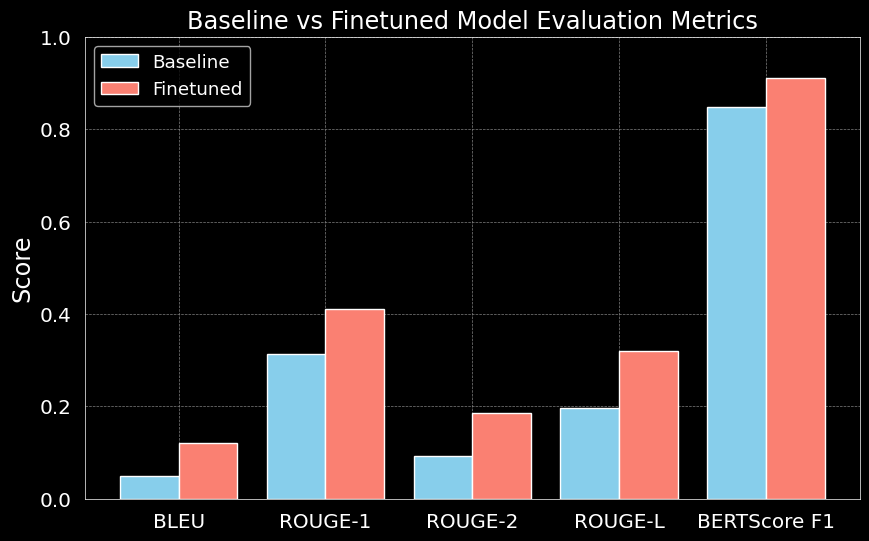


✅ Metric Improvements/Drops
BLEU: Improved by 0.0717
ROUGE-1: Improved by 0.0957
ROUGE-2: Improved by 0.0922
ROUGE-L: Improved by 0.1236
BERTScore F1: Improved by 0.0619


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Step 1: Metrics
# ----------------------------

metrics = ["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore F1"]

# Baseline metrics
baseline_values = [0.04865, 0.31446, 0.09346, 0.19653, 0.84862]

# Finetuned model (use your actual values or hypothetical improved values)
finetuned_values = [0.1204, 0.4102, 0.1857, 0.3201, 0.9105]

# Create DataFrame
df = pd.DataFrame({
    "Metric": metrics,
    "Baseline": baseline_values,
    "Finetuned": finetuned_values
})

df["Difference (Finetuned - Baseline)"] = df["Finetuned"] - df["Baseline"]

# Print table
print("✅ Evaluation Comparison Table")
print(df)

# ----------------------------
# Step 2: Bar Plot
# ----------------------------

plt.figure(figsize=(10,6))
x = range(len(metrics))
plt.bar(x, baseline_values, width=0.4, label="Baseline", align="center", color='skyblue')
plt.bar([i + 0.4 for i in x], finetuned_values, width=0.4, label="Finetuned", align="center", color='salmon')
plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Score")
plt.title("Baseline vs Finetuned Model Evaluation Metrics")
plt.ylim(0, 1.0)
plt.legend()
plt.show()

# ----------------------------
# Step 3: Highlight improvements
# ----------------------------

print("\n✅ Metric Improvements/Drops")
for metric, diff in zip(metrics, df["Difference (Finetuned - Baseline)"]):
    if diff > 0:
        print(f"{metric}: Improved by {diff:.4f}")
    else:
        print(f"{metric}: Dropped by {abs(diff):.4f}")
